In [1]:
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.table import Table
from astroquery.simbad import Simbad
import arviz as az

plt.rcParams['figure.facecolor']    = 'white'
import pandas as pd    
from datetime import date
today=date.today()
DATE =today.strftime("%m_%d_%y")
print(DATE)
# from utils import *

01_23_25


In [2]:
import sys
# sys.path.append('/path/to/the/folder/of/your/module/file')
sys.path

['/Users/maryumsayeed/Desktop/Code/Research/espresso_lirich/scripts',
 '/opt/miniconda3/lib/python39.zip',
 '/opt/miniconda3/lib/python3.9',
 '/opt/miniconda3/lib/python3.9/lib-dynload',
 '',
 '/opt/miniconda3/lib/python3.9/site-packages',
 '/opt/miniconda3/lib/python3.9/site-packages/certifi-2022.9.24-py3.9.egg',
 '/opt/miniconda3/lib/python3.9/site-packages/ipython_genutils-0.2.0-py3.9.egg',
 '/opt/miniconda3/lib/python3.9/site-packages/fits2hdf-1.1.1-py3.9.egg',
 '/opt/miniconda3/lib/python3.9/site-packages/IPython/extensions',
 '/Users/maryumsayeed/.ipython']

In [3]:
#pip install thejoker

In [4]:
import thejoker as tj
import thejoker.units as xu
from utils import PLOT_PARAMS
import pymc as pm
import corner
import arviz as az

In [5]:
#p112 = glob.glob('../data/spectra/*.fits')


In [6]:
files = glob.glob('../data/P112_data/*.fits')

In [7]:

hdul = fits.open(files[0])
header  = hdul[0].header


In [8]:
def get_galah():
    galah =(Table.read('../../lithium/data/GALAH_DR3_main_allstar_v2.fits',format='fits'))#.to_pandas()

    dr2_ids = np.array(galah['dr2_source_id']).astype('str')
    dr3_ids = np.array(galah['dr3_source_id']).astype('str')
    
    galah.remove_column('dr2_source_id')
    galah.remove_column('dr3_source_id')
    galah = galah.to_pandas()

    galah.insert(2, 'dr2_source_id', dr2_ids)
    galah.insert(3, 'dr3_source_id', dr3_ids)
    
    galah['ph_qual_wise']=galah['ph_qual_wise'].str.decode("utf-8")
    return galah
galah=get_galah()

In [9]:
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u

vlt = EarthLocation.of_site('paranal')  # the easiest way... but requires internet

In [10]:
# spectrum = fits.open('../data/spectra/archive/ADP.2023-12-08T12:58:09.704.fits')
# header = spectrum[0].header
# data   = spectrum[1].data

In [11]:
# instrument precision: cm/s
# decription of columns: https://ftp.eso.org/pub/dfs/pipelines/instruments/espresso-das/espda-reflex-tutorial-1.3.7.pdf
# QC CCF RV: computed radial velocity [km s−1

In [12]:
# from: https://www.eso.org/rm/api/v1/public/releaseDescriptions/176
# Barycentric correction. The wavelengths in the science spectrum are correct to the barycentre of
# the solar system. 

In [13]:
# header.cards

In [14]:
obj_dir = {}
c=3e5 #km/s

for i,file in enumerate(files):
    with fits.open(file) as hdul:
        hdul = fits.open(file)
        header  = hdul[0].header
        #print(header.cards['HIERARCH ESO QC CCF RV ERROR'])
        data    = hdul[1].data
        time    = header['HIERARCH ESO QC BJD']
        name    = header['OBJECT']
        obj     = int(header['HIERARCH ESO OBS NAME'].split('-')[0][2:])
        grade   = header['OB_GRADE'].replace(" ", "")
        if grade =='C':
            print('RG',obj,header['OB_GRADE'])
            continue
            
        ra,dec  = header['RA'], header['DEC']
        obs_T   = header['DATE-OBS'].split('T')[0]
        rv_val  =  header['HIERARCH ESO QC CCF RV']#header['HIERARCH ESO OCS OBJ RV'] #km/s
        rv_err  = header['HIERARCH ESO QC CCF RV ERROR'] #km/s
        sc = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
        rv_corr = rv_val
        err_corr = rv_err
        # correct for Earth's motion:
#         rv_corr = sc.radial_velocity_correction(kind='barycentric', obstime=Time(obs_T), location=vlt).to(u.km/u.s).value #to convert to km/s
#         err_corr = sc.radial_velocity_correction(kind='barycentric', obstime=Time(obs_T), location=vlt).to(u.km/u.s).value
#         rv_corr = rv_val + rv_corr + rv_val * rv_corr / c  
        #err_corr = rv_err + err_corr + rv_err * err_corr / c  
        
        if obj in obj_dir.keys():
            obj_dir[obj]['rv'].append(rv_corr)
            obj_dir[obj]['time'].append(time)
            obj_dir[obj]['err'].append(err_corr)
            obj_dir[obj]['name'].append(name)
            obj_dir[obj]['grade'].append(grade)
        else:
            obj_dir[obj] = {'rv': [rv_corr], 'time': [time], 'err': [err_corr], 'name': [name], 'grade': [grade]}
print(len(obj_dir.keys()))   
targets_to_remove = []
for k, v in obj_dir.items():
    if len(v['time']) < 3:
        targets_to_remove.append(k)
for i in range(len(targets_to_remove)):
    del obj_dir[targets_to_remove[i]]
print(len(obj_dir.keys()))

myKeys = list(obj_dir.keys())
myKeys.sort()
obj_dir = {i: obj_dir[i] for i in myKeys}
 

RG 20 C
RG 13 C
RG 14 C
RG 1 C
19
10


In [15]:
new_df = {'RG_id':[], 'galah_id': [], 'obj_name': []}

for k, v in obj_dir.items():
    if k== 24: 
        continue
    result_table = Simbad.query_objectids(v['name'][0])
    result_table = np.array(result_table).astype('str')
    for i in result_table:
        if 'GALAH' in i:
            galah_name = i.split(' ')[-1]
            
    new_df['RG_id'].append(k)
    new_df['galah_id'].append(int(galah_name))
    new_df['obj_name'].append(v['name'][0])

new_df['RG_id'].append(24)
new_df['galah_id'].append(171208003602294)
new_df['obj_name'].append('UCAC4 202-005918')

new_df = pd.DataFrame(new_df)

new_df = pd.merge(new_df, galah[['sobject_id', 'vbroad', 'fe_h', 'Li_fe', 'ruwe_dr2']], left_on='galah_id', right_on='sobject_id')
new_df['Li_val'] = new_df.fe_h+new_df.Li_fe+1.05
cols = ['RG_id', 'galah_id', 'obj_name', 'Li_val', 'vbroad', 'fe_h','ruwe_dr2']
new_df=new_df[cols]
new_df

,RG_id,galah_id,obj_name,Li_val,vbroad,fe_h,ruwe_dr2
0,1,150107004201104,UCAC4 297-057956,3.410536,11.289165,-0.284913,0.891505
1,2,151230003202196,UCAC4 159-007674,2.099899,11.365773,-0.279406,0.964961
2,4,161013005401317,TYC 763-2824-1,2.684311,8.791462,-0.472353,0.925293
3,5,161104004801189,UCAC4 374-013344,2.961795,7.485142,-0.641548,0.985867
4,6,150829004301285,UCAC4 250-188426,1.788579,7.947460,-0.424970,1.032038
5,7,160129003601260,UCAC4 314-010619,2.602532,10.028137,-0.213539,0.996055
6,13,190212001601338,2MASS J05354326-0034367,3.338972,19.171839,-0.004679,0.930756
7,14,140311007101261,UCAC4 220-051792,3.235595,15.261668,0.001983,1.019649
8,23,170514002101318,CD-69 769,1.860608,13.344526,0.056030,1.035240
9,24,171208003602294,UCAC4 202-005918,3.762650,17.888702,-0.698843,1.072554


1
2
4
5
6
7
13
14
23
24


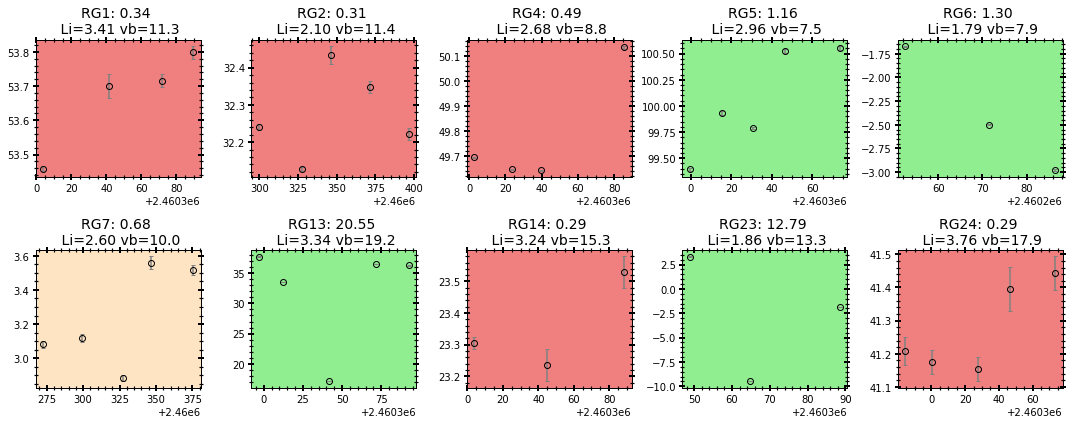

In [16]:
#PLOT_PARAMS(LS=12)

stats = {'RG_id':[], 'A': []}
plt.figure(figsize=(15,6))
for i, (obj, dat) in enumerate(obj_dir.items()):
    if len(dat['time']) > 1:
        #print(obj,obj_dir[obj])
        ax=plt.subplot(2,5,i+1)
        time    = np.array(obj_dir[obj]['time'])
        rv_vals = np.array(obj_dir[obj]['rv'])
        yerr    = np.array(obj_dir[obj]['err'])
            
        t0  = time[0]
        rv0 = rv_vals[0]
        K0 = (max(rv_vals)-min(rv_vals))/2.
        
        plt.errorbar(time, rv_vals, 
                     yerr=yerr,
                     fmt='o', color='grey', mec='k', mfc='None', capsize=2)
        #plt.axhline(0, color='k',lw=1,ls='dotted')

        diff = abs(max(rv_vals)-min(rv_vals))
        if diff < 0.5:
            ax.set_facecolor('lightcoral')
        elif 0.5 <= diff < 0.7:
            ax.set_facecolor('bisque')
        elif 0.7 <= diff <= 50:
            ax.set_facecolor('lightgreen')
        print(obj)
        li = new_df[new_df.RG_id==obj]['Li_val'].values[0]
        vb = new_df[new_df.RG_id==obj]['vbroad'].values[0]
        #li, vb = new_df[new_df.RG_id==obj][['Li_val','vbroad']].values()[0]
        title = 'RG%s: %.2f \n Li=%.2f vb=%.1f'%(obj,diff,li, vb)
        plt.title(title)
        stats['RG_id'].append(obj)
        stats['A'].append(diff)

#         elif title in ['RG4','RG24','RG13','RG7']:
#             ax.set_facecolor('lightblue')
        #if i >= 20: plt.xlabel(r'BJD Time [days]')
    #if i+1 in [1,5,9,13]: plt.ylabel(r'RV [km/s]')

plt.tight_layout()

stats = pd.DataFrame(stats)

# plt.savefig('../plots/init_%s.png'%DATE, bbox_inches='tight', dpi=200)

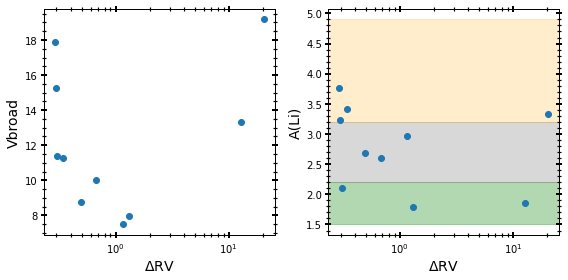

In [17]:
params = pd.merge(new_df, stats, on='RG_id')
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.scatter(params.A, params.vbroad)
plt.xscale('log')
plt.xlabel('$\Delta$RV')
plt.ylabel('Vbroad')

plt.subplot(122)
plt.scatter(params.A, params.Li_val)
plt.axhspan(1.5, 2.2, color='green',alpha=0.3,zorder=0)
plt.axhspan(2.2, 3.2, color='grey',alpha=0.3,zorder=0)
plt.axhspan(3.2, 4.9, color='orange',alpha=0.2,zorder=0)
plt.xscale('log')
plt.xlabel('$\Delta$RV')
plt.ylabel('A(Li)')
plt.tight_layout()

In [24]:
def test_tj(obj,Pi,Pf=1000,K0=20,error=0.1,chains=2, prior_size=50_000,save=False,MCMC=False):
    data = Table()
    data['bjd'] = obj_dir[obj]['time']
    data['rv'] = obj_dir[obj]['rv']
    print('mean error originally: %.3f km/s'%np.mean(np.array(obj_dir[obj]['err'])))
    data['rv_err'] = np.array(obj_dir[obj]['err'])#*5
    data['rv_err'] = np.array([error]*len(data['rv']))
    print('mean error now: %.3f km/s'%np.mean(data['rv_err']))
    
    t = Time(data["bjd"], format="jd", scale="tcb")
    
    rnd = np.random.default_rng(seed=42)
    
    data = tj.RVData(t=t, rv=data["rv"]*u.km/u.s, rv_err=data["rv_err"]*u.km/u.s)
    
    with pm.Model() as model:
        #P_prior = xu.with_unit(pm.Uniform("P", 0.25, 1e3), u.day)
        #M0_prior    = xu.with_unit(pm.Uniform("M0", -np.pi, np.pi), u.radian)
        #omega_prior = xu.with_unit(pm.Uniform("omega", -np.pi, np.pi), u.radian)
        
        #s_prior = xu.with_unit(pm.Normal("s", 0, 0.5), u.km/u.s)
        #K_prior = xu.with_unit(pm.Normal("K", 0, 20), u.km/u.s)
        #e_prior = xu.with_unit(pm.Uniform("e", 0, 1), u.one)
        
        prior = tj.JokerPrior.default(
                P_min = Pi * u.day, # to use Joker's default log-normal, give P-min, P-max
                P_max = Pf * u.day,
                sigma_K0 = K0 * u.km / u.s,
                sigma_v = 100 * u.km / u.s,
#                 sigma_v=[100 * u.km / u.s, 
#                           0.5 * u.km / u.s / u.day, 
#                           1e-2 * u.km / u.s / u.day**2],
#                 poly_trend=3,
#                       #'M0':M0_prior,
#                       #'omega':omega_prior,
#                       #'e': e_prior,
#                       'K': K_prior, 
        )

    prior_samples = prior.sample(size=prior_size, rng=rnd)
    print(prior_samples)
    
    joker = tj.TheJoker(prior, rng=rnd)

    joker_samples = joker.rejection_sample(data, prior_samples, 
                                           max_posterior_samples=256,
                                           return_all_logprobs=True)
    print(joker_samples[0])
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    _ = tj.plot_rv_curves(
        joker_samples[0],
        data=data,
        relative_to_t_ref=True,
        ax=ax,
    )
    
    ax.set_xlabel(f"BMJD$ - {data.t.tcb.mjd.min():.3f}$")
#     ax.set_xlabel(f"BMJD$ - {data.t.min():.3f}$")
    if save: fig.savefig('../rv_fit/fit_RG%s_%s_2.png'%(obj,DATE),bbox_inches='tight',dpi=100)
    if MCMC:
        
        with prior.model:
            mcmc_init = joker.setup_mcmc(data, joker_samples[0])
            trace = pm.sample(tune=2000, draws=2000, start=mcmc_init, cores=1, chains=2)

        az.summary(trace, var_names=prior.par_names)
        print('MCMC samples...')
        mcmc_samples = tj.JokerSamples.from_inference_data(prior, trace, data)
        mcmc_samples.wrap_K()
        df = mcmc_samples.tbl.to_pandas()
        colnames = []
        # ==== 3 body ====
        #truth = ['P','e','omega','M0','K','v0', 'v1', 'v2']
        #truth = ['P','e','K','v0', 'v1', 'v2']
        # ==== 2 body ====
        #truth = ['P','e','omega','M0','K','v0']
        truth = ['P','e','K','v0']
        for name in df.columns:
            if name in truth:
                colnames.append(name)
                #truths.append(truth[name].value)
        fig = corner.corner(df[colnames])#, truths=truths)
        if save: fig.savefig('../rv_fit/corner_RG%s_%s.png'%(obj, DATE),bbox_inches='tight',dpi=200)
    return prior_samples, joker_samples, mcmc_samples, trace, prior.par_names#az.summary(trace, var_names=prior.par_names)


## test out jitter fitting (based on Dan's recommendation)

In [27]:
obj_to_run = {}

6
mean error originally: 0.007 km/s
mean error now: 0.100 km/s
<JokerSamples [e, omega, M0, s, P] (2000000 samples)>
<JokerSamples [P, e, omega, M0, s, K, v0] (256 samples)>


<ipython-input-24-aff3f0c675d0>:64: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(tune=2000, draws=2000, start=mcmc_init, cores=1, chains=2)
Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc.sampling.mcmc:Sequential sampling (2 chains in 1 job)
NUTS: [e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, P, K, v0]
INFO:pymc.sampling.mcmc:NUTS: [e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, P, K, v0]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 169 seconds.
INFO:pymc.sampling.mcmc:Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 169 seconds.
There were 392 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:There were 392 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per cha

MCMC samples...


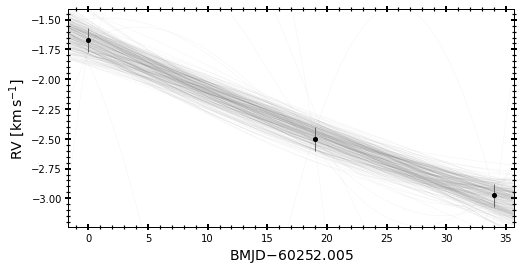

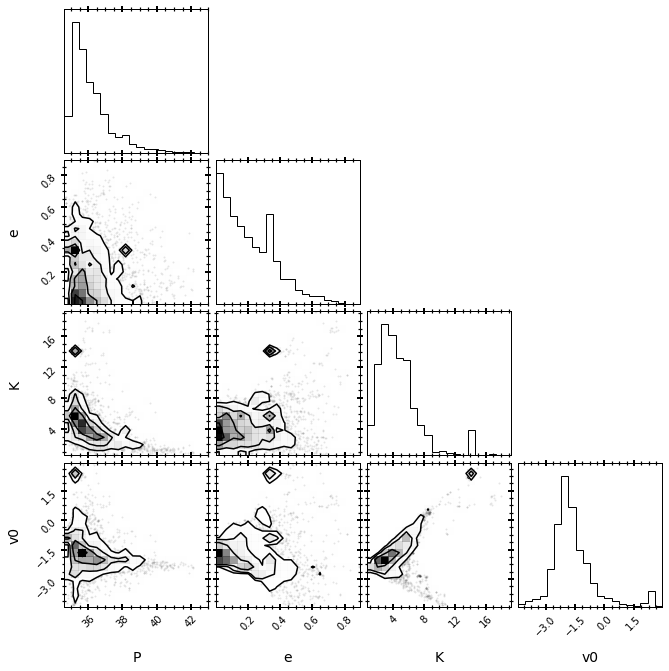

In [48]:


import pickle

program = 'p112'
version = 1
# 2 body
for k in [6]:
    print(k)
    obj_to_run[k] = [test_tj(k, Pi=30, Pf=500, K0=10, chains=2, prior_size=2_000_000, save=False, MCMC=True)]
    
    save_dir = '../mcmc/%s/%s_mcmc_%s.pickle'%(program,k,version)
#     with open(save_dir, 'wb') as handle:
#         pickle.dump(obj_to_run[k][0][2], handle, protocol=pickle.HIGHEST_PROTOCOL)

    # save trace
    save_dir = '../mcmc/%s/%s_trace_%s.pickle'%(program,k,version)
#     with open(save_dir, 'wb') as handle:
#         pickle.dump(obj_to_run[k][0][-2], handle, protocol=pickle.HIGHEST_PROTOCOL)



In [ ]:
ss

In [46]:
binaries_in_112 = [6, 7, 13, 23]

In [47]:
# save joker_samples

program  = 'p112'
version  = 1

for obj in binaries_in_112:
    save_dir = '../mcmc/%s/%s_joker_%s.hdf5'%(program,obj,version)
    print(save_dir)
    #obj_to_run[obj][0][1][0].write(save_dir, overwrite=True)
    
# with open(save_dir, 'wb') as handle:
#     pickle.dump(obj_to_run[obj][0][1][0], handle, protocol=pickle.HIGHEST_PROTOCOL)


../mcmc/p112/6_joker_1.hdf5
../mcmc/p112/7_joker_1.hdf5
../mcmc/p112/13_joker_1.hdf5
../mcmc/p112/23_joker_1.hdf5


In [52]:
obj_to_run[obj][0][1][0]

<JokerSamples [P, e, omega, M0, s, K, v0] (256 samples)>

In [ ]:
ss

In [ ]:
obj_to_run = {6:[], 7:[], 13:[], 23:[]}

In [ ]:
obj_to_run[23] = [test_tj(23, prior_size=1_000_000, save=False, MCMC=True)]


In [ ]:
obj_to_run[13] = [test_tj(13, prior_size=2_000_000, save=False, MCMC=True)]


In [ ]:
for k, v in obj_to_run.items():
    print(k)
    obj_to_run[k] = [test_tj(k, prior_size=1_000_000, save=False, MCMC=True)]

    # save mcmc
    save_dir = '../mcmc/%s/%s_mcmc_%s.pickle'%(program,k,DATE)
    with open(save_dir, 'wb') as handle:
        pickle.dump(obj_to_run[k][0][2], handle, protocol=pickle.HIGHEST_PROTOCOL)
                                  
    # save trace
    save_dir = '../mcmc/%s/%s_trace_%s.pickle'%(program,k,DATE)
    with open(save_dir, 'wb') as handle:
        pickle.dump(obj_to_run[k][0][-2], handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
obj_to_run[7][0]#['ln_likelihood']

In [ ]:
obj_to_run[7][0][-2]

In [ ]:
def test_phase_fold(obj):
    data = Table()
    data['bjd'] = obj_dir[obj]['time']
    data['rv'] = obj_dir[obj]['rv']
    print('mean error originally: %.3f km/s'%np.mean(np.array(obj_dir[obj]['err'])))
    data['rv_err'] = np.array(obj_dir[obj]['err'])
    data["rv"].unit = u.km / u.s
    data["rv_err"].unit = u.km / u.s
    
    data = tj.RVData(
        t=Time(data["bjd"], format="jd", scale="tcb"),
        rv=u.Quantity(data["rv"]),
        rv_err=u.Quantity(data["rv_err"]))
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    mcmc_samples = obj_to_run[obj][0][2]
    print(mcmc_samples.mean())
    _=tj.plot_phase_fold(mcmc_samples.mean(),
        data=data,
        relative_to_t_ref=True,
        ax=ax,
    )
test_phase_fold(7)

In [ ]:
b

In [ ]:
ss

In [ ]:
obj_to_run = {1:[], 2:[], 4:[], 13:[], 24:[]}

In [ ]:
# RG 13 run with default priors in P and e
ps_13, js_13, ms_13, trace_13, par_names_13 = test_tj(13, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)


In [ ]:
# RG 6 run with default priors in P and e
ps_6, js_6, ms_6, trace_6, par_names_6 = test_tj(6, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)


In [ ]:
# RG 5 run with default priors in P and e
ps_5, js_5, ms_5, trace_5, par_names_5 = test_tj(5, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)


In [ ]:
# RG 7 run with default priors in P and e
ps_7, js_7, ms_7, trace_7, par_names_7 = test_tj(7, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)


In [ ]:
# RG 23 run with default priors in P and e
ps_23_2body, js_23_2body, ms_23_2body, trace_23_2body, par_names_23_2body = test_tj(23, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)


In [ ]:
# RG 13 run with default priors in P and e
ps_13_2body, js_13_2body, ms_13_2body, trace_13_2body, par_names_13_2body = test_tj(13, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)


In [ ]:
# RG 6 run with default priors in P and e
ps_6_2body, js_6_2body, ms_6_2body, trace_6_2body, par_names_6_2body = test_tj(6, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)


In [ ]:
# RG 5 run with default priors in P and e
ps_5_2body, js_5_2body, ms_5_2body, trace_5_2body, par_names_5_2body = test_tj(5, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)


In [ ]:
# RG 7 run with default priors in P and e
ps_7_2body, js_7_2body, ms_7_2body, trace_7_2body, par_names_7_2body = test_tj(7, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)


In [ ]:
# RG 23 run with default priors in P and e
ps_23, js_23, ms_23, trace_23, par_names_23 = test_tj(23, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)
